In [1]:
from keras import applications
from keras import models
from keras import layers
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dropout, Flatten, Dense, Input, Activation, GlobalAveragePooling2D, GlobalMaxPooling2D, MaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras import regularizers
import matplotlib.pyplot as plt
from keras.models import load_model
from keras.utils import layer_utils, np_utils
from keras.callbacks import ModelCheckpoint
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.datasets import make_classification
from sklearn.preprocessing import label_binarize
from scipy import interp
from itertools import cycle
from sklearn.metrics import roc_curve, auc
from keras.models import Model
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing import image
from keras import backend as K
from keras.callbacks import LearningRateScheduler
import math

Using TensorFlow backend.


In [2]:
train_dir = "D:/retinal_data_set_visioncare/TrainValidationData/augmented_train_data_224"
validation_dir = "D:/retinal_data_set_visioncare/TrainValidationData/validation"

image_width = 299
image_height = 299
batchsize = 16

InceptionV3_model = applications.InceptionV3(weights='imagenet', include_top=False, input_shape=(image_width, image_height, 3))

In [3]:
# Freeze the layers except the last 2 layers
for layer in InceptionV3_model.layers[:]:
    layer.trainable = False

# Check the trainable status of the individual layers
for layer in InceptionV3_model.layers:
    print(layer, layer.trainable)

<keras.engine.topology.InputLayer object at 0x0000012F1D767BA8> False
<keras.layers.convolutional.Conv2D object at 0x0000012F1D767F60> False
<keras.layers.normalization.BatchNormalization object at 0x0000012F1D767D30> False
<keras.layers.core.Activation object at 0x0000012F1D767EF0> False
<keras.layers.convolutional.Conv2D object at 0x0000012F1D786128> False
<keras.layers.normalization.BatchNormalization object at 0x0000012F1D786550> False
<keras.layers.core.Activation object at 0x0000012F2247B828> False
<keras.layers.convolutional.Conv2D object at 0x0000012F22865438> False
<keras.layers.normalization.BatchNormalization object at 0x0000012F2287CC50> False
<keras.layers.core.Activation object at 0x0000012F22928748> False
<keras.layers.pooling.MaxPooling2D object at 0x0000012F2294F320> False
<keras.layers.convolutional.Conv2D object at 0x0000012F22960048> False
<keras.layers.normalization.BatchNormalization object at 0x0000012F22BC18D0> False
<keras.layers.core.Activation object at 0x000

In [4]:
InceptionV3_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 299, 299, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 149, 149, 32) 96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 149, 149, 32) 0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_2 (

In [5]:
def dataGen():
    train_datagen = ImageDataGenerator(rescale=1./255)
    validation_datagen = ImageDataGenerator(rescale=1./255)
    
    train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(image_width, image_height),
        batch_size=batchsize,
        shuffle=True,
        class_mode='categorical')
    
    validation_generator = validation_datagen.flow_from_directory(
            validation_dir,
            target_size=(image_width, image_height),
            batch_size=batchsize,
            class_mode='categorical',
            shuffle=False)
    
    return train_generator, validation_generator

In [6]:
def trainValidationAccuracy(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(acc))

    plt.plot(epochs, acc, 'b', label='Training acc')
    plt.plot(epochs, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()

    plt.figure()

    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

    plt.show()

In [7]:
def step_decay(epoch):
    lr_0 = 0.0008
    decay_rate = 10
    lrate = lr_0 * 1/(1+decay_rate * epoch)
    return lrate

In [12]:
def modelBuilder(train_generator, validation_generator, intermediate_layer_model, path):   
    # Compile the model
    #optimizer=optimizers.adam(lr=0.0008)
    intermediate_layer_model.compile(loss='categorical_crossentropy',
                  optimizer=optimizers.adam(lr=1e-4, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0),
                  metrics=['acc'])
    model_check_point_loc = 'D:/retinal_data_set_visioncare/models/inceptionV3/' + path
    model_checkpoint = ModelCheckpoint(model_check_point_loc, monitor='val_acc', verbose=0, save_best_only=True, mode='max')
    # learning schedule callback
    #lrate = LearningRateScheduler(step_decay)
    # Train the model
    history = intermediate_layer_model.fit_generator(
          train_generator,
          steps_per_epoch=train_generator.samples//train_generator.batch_size,
          epochs=20,
          callbacks=[model_checkpoint],
          validation_data=validation_generator,
          validation_steps=validation_generator.samples//validation_generator.batch_size,
          verbose=1)
    trainValidationAccuracy(history)

In [13]:
train_generator, validation_generator = dataGen()

Found 5000 images belonging to 5 classes.
Found 281 images belonging to 5 classes.


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 299, 299, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 149, 149, 32) 96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 149, 149, 32) 0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_2 (

Epoch 1/20
312/312 [==============================] - 243s 778ms/step - loss: 5.1484 - acc: 0.4349 - val_loss: 4.3592 - val_acc: 0.6250
Epoch 2/20
312/312 [==============================] - 240s 771ms/step - loss: 3.8634 - acc: 0.5675 - val_loss: 3.5499 - val_acc: 0.5846
Epoch 3/20
312/312 [==============================] - 241s 772ms/step - loss: 3.1450 - acc: 0.6152 - val_loss: 3.1884 - val_acc: 0.4853
Epoch 4/20
312/312 [==============================] - 240s 771ms/step - loss: 2.6696 - acc: 0.6360 - val_loss: 2.6483 - val_acc: 0.6176
Epoch 5/20
312/312 [==============================] - 241s 771ms/step - loss: 2.3119 - acc: 0.6655 - val_loss: 2.3670 - val_acc: 0.6176
Epoch 6/20
312/312 [==============================] - 240s 770ms/step - loss: 2.0499 - acc: 0.6781 - val_loss: 2.2066 - val_acc: 0.6103
Epoch 7/20
312/312 [==============================] - 240s 770ms/step - loss: 1.8385 - acc: 0.6923 - val_loss: 2.0267 - val_acc: 0.5993
Epoch 8/20
312/312 [============================

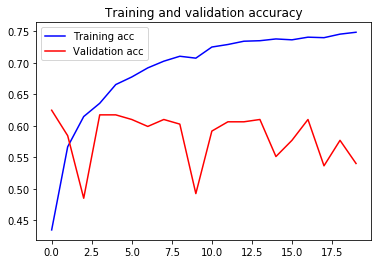

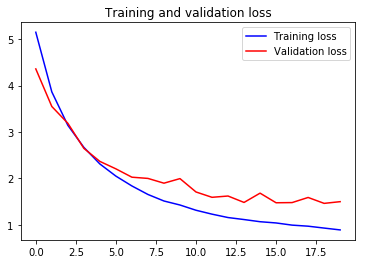

In [14]:
output = InceptionV3_model.get_layer(index = -1).output
output = GlobalAveragePooling2D()(output)
# let's add a fully-connected layer
output = Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.01))(output)
output = Dropout(0.5)(output)
# and a logistic layer -- let's say we have 200 classes
output = Dense(5, activation='softmax')(output)

model = Model(InceptionV3_model.input, output)
model.summary()

modelBuilder(train_generator, validation_generator, model, 'InceptionV3_dr_rmFCdrp.h5')